# CS396 Data Science Project

### Project Overview
This project aims to understand any underlying biases or trends on Yelp by answering the following questions:
1. Is there a correlation between a user's activity and their average review star rating?
2. Is a review's text length indicative of its star rating?
3. Does whether a review was made during business hours correlate with its star rating?
4. Is there a relationship between a business' number of reviews and its star rating?

### Data Used
All of these questions were answered using various data sources included in the Yelp Open Dataset. The specific files used for each question are listed below:
1. user.json
2. review.json
3. review.json, business.json
4. business.json

## Environment Setup and Utility Functions

In [108]:
DATA_PATH = '../../yelp_dataset/'

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime


def load_data(path):
    """Load Yelp data file
    Currently only JSON and pickle format supported
    
    function(string) => pd.DataFrame"""
    f_type = path.split('.')[-1]
    
    if f_type == 'json': 
        return pd.DataFrame.from_records([json.loads(l) for l in open(DATA_PATH+path, encoding='utf-8')])
    elif f_type in ['pickle', 'pkl']:
        return pd.read_pickle(DATA_PATH+path)
    else:
        raise ValueError('Unsupported file type provided "{0}"'.format(f_type))
        

def save_data(df, path):
    """Save pd.DataFrame to specified file
    Currently only JSON and pickle format supported
    
    function(pd.DataFrame, string) => None"""
    f_type = path.split('.')[-1]
    
    if f_type == 'json':
        with open(DATA_PATH+path, 'w', encoding='utf-8') as out:
            for i, r in df.iterrows():
                print(r.to_json(), file=out)
        return
    elif f_type in ['pickle', 'pkl']:
        df.to_pickle(DATA_PATH+path)
        return
    else:
        raise ValueError('Unsupported file type provied "{0}"'.format(f_type))
 

def drop_null(df, subset=None):
    """Remove null values (or subset) and return statistics
    
    function(pd.DataFrame, List[String]) => pd.DataFrame, Number, Number
    """
    # Remove null data
    clean = df.dropna() if not subset else df.dropna(subset=subset)
    
    # Compute statistics
    num_null = len(df) - len(clean)
    percent_null = (num_null / len(df)) * 100
    
    return clean, num_null, percent_null   


def in_business_hours(review_time, business_hours):
    """Determine if a review time is within a business' operating hours
    
    function(String, Dict) => Boolean
    """
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    rev_time = datetime.strptime(review_time, '%Y-%m-%d %H:%M:%S')
    rev_dow = weekdays[rev_time.weekday()]

    if rev_dow not in business_hours.keys():
        return False
    
    bus_hours = business_hours[rev_dow].split('-')
    open_time = datetime.strptime(bus_hours[0], '%H:%M')
    clos_time = datetime.strptime(bus_hours[1], '%H:%M')
    
    return open_time.time() <= rev_time.time() <= clos_time.time()

## Data Cleaning

### Convert JSON to Pickle
All of the data files that will be used are converted to pickle format for significantly faster load times and performance. This process takes a long time to complete (>20 minutes on my system) and requires significant computational resources (>8 GB RAM usage), but saves time in the long run with significantly decreased loading times for later access. This also slightly increases data density, saving about 1 GB in total across the files transcoded.

In [50]:
'''
# Commented out to prevent accidental execution
files = ['yelp_academic_dataset_user', 'yelp_academic_dataset_review', 'yelp_academic_dataset_business']
for f in files:
    df = load_data(f+'.json')
    save_data(df, f+'.pickle')
'''

### General Data Cleaning
The cleaning for each dataset is handled by its own clean_{dataset} function. This allows for more precising cleaning to be added in the future in the event that it is needed. For the analysis that will be performed here, there is very little data cleaning that needs to be performed; aside from dropping null values, the user and business datasets need to be checked for duplicate user_id and business_id respectively. Upon analyzing the data used here, there were no such duplicates found, so the currently implementation of clean_{dataset} only serves as an alert of duplicate entries. There is no need to resolve any textual errors, such as an incorrect city name, as those will not be analyzed in this project and do not affect the other results. After the initial EDA, it was determined that users with more than 10,000 reviews are extreme outliers from the data and thus are removed in the data cleaning process.

#### User Data Cleaning

In [2]:
def clean_user(df):
    """Apply cleaning to user dataset or a subset of it
    
    function(pd.DataFrame) => pd.DataFrame
    """
    print('=== User Data Cleaning Results ===')
    
    # Clean out entries with null values
    clean, num_null, percent_null = drop_null(df)
    print('  Null entries dropped:  {0} ({1}%)'.format(num_null, round(percent_null, 2)))
    
    # Ensure no duplicate user_ids
    num_duplicates = len(clean) - len(clean.user_id.unique())
    print('  Duplicate user_id:     {0}'.format(num_duplicates))
    
    # Remove extreme activity outliers
    REVIEW_LIMIT = 10000
    print('  Outliers removed:      {0}'.format(sum(clean.review_count >= REVIEW_LIMIT)))
    clean = clean[clean.review_count < REVIEW_LIMIT]
    
    return clean

In [59]:
df = load_data('yelp_academic_dataset_user.pickle')
df = clean_user(df)

=== User Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)
  Duplicate user_id:     0
  Outliers removed:      4


#### Business Data Cleaning

In [106]:
def clean_business(df):
    """Apply cleaning to business dataset or a subset of it
    
    function(pd.DataFrame) => pd.DataFrame
    """
    print("=== Business Data Cleaning Results ===")
    
    # Clean out null values
    clean, num_null, percent_null = drop_null(df, subset=['stars', 'review_count', 'is_open', 'hours'])
    print('  Null entries dropped:   {0} ({1}%)'.format(num_null, round(percent_null, 2)))
    
    # Ensure no duplicate business_id's
    num_duplicates = len(clean) - len(clean.business_id.unique())
    print('  Duplicate business_id:  {0}'.format(num_duplicates))
    
    return clean

In [22]:
df = load_data('yelp_academic_dataset_business.pickle')
df = clean_business(df)

=== Business Data Cleaning Results ===
  Null entries dropped:   27341 (17.03%)
  Duplicate business_id:  0


#### Review Data Cleaning

In [4]:
def clean_review(df):
    """Apply cleaning to review dataset or a subset of it
    
    function(pd.DataFrame) => pd.DataFrame
    """
    print("=== Review Data Cleaning Results ===")
    
    # Clean out null values
    clean, num_null, percent_null = drop_null(df)
    print('  Null entries dropped:  {0} ({1}%)'.format(num_null, round(percent_null, 2)))
    
    return clean

In [12]:
df = load_data('yelp_academic_dataset_review.pickle')
df = clean_review(df)

=== Review Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)


## Exploratory Data Analysis

### Business Data

In [77]:
df = clean_business(load_data('yelp_academic_dataset_business.pickle'))

=== Business Data Cleaning Results ===
  Null entries dropped:   0 (0.0%)
  Duplicate business_id:  0


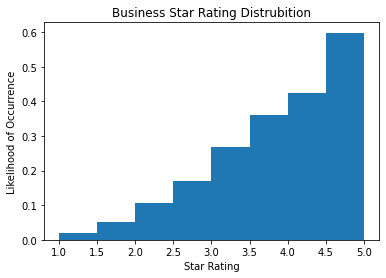

In [78]:
plt.hist(df.stars, bins=[1,1.5,2,2.5,3,3.5,4,4.5,5], density=True)
plt.title('Business Star Rating Distrubition')
plt.ylabel('Likelihood of Occurrence')
plt.xlabel('Star Rating')
plt.show()

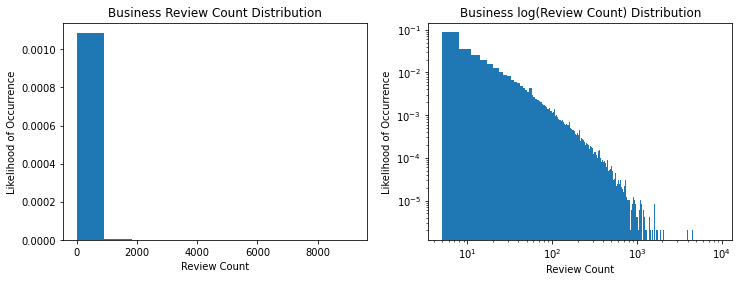

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(df.review_count, density=True)
ax[0].set_title('Business Review Count Distribution')
ax[0].set_ylabel('Likelihood of Occurrence')
ax[0].set_xlabel('Review Count')

ax[1].hist(df.review_count, 3000, density=True)
ax[1].set_title('Business log(Review Count) Distribution')
ax[1].set_ylabel('Likelihood of Occurrence')
ax[1].set_yscale('log')
ax[1].set_xlabel('Review Count')
ax[1].set_xscale('log')

plt.show()

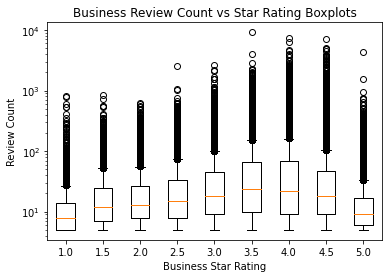

In [84]:
star_values = [i*0.5 + 0.5 for i in range(1,10)]
star_bins = [df[df.stars==s].review_count for s in star_values]

plt.boxplot(star_bins)
plt.xticks(list(range(1,10)), star_values)
plt.title('Business Review Count vs Star Rating Boxplots')
plt.ylabel('Review Count')
plt.yscale('log')
plt.xlabel('Business Star Rating')
plt.show()

### User Data

In [110]:
df = clean_user(load_data('yelp_academic_dataset_user.pickle'))

=== User Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)
  Duplicate user_id:     0
  Outliers removed:      4


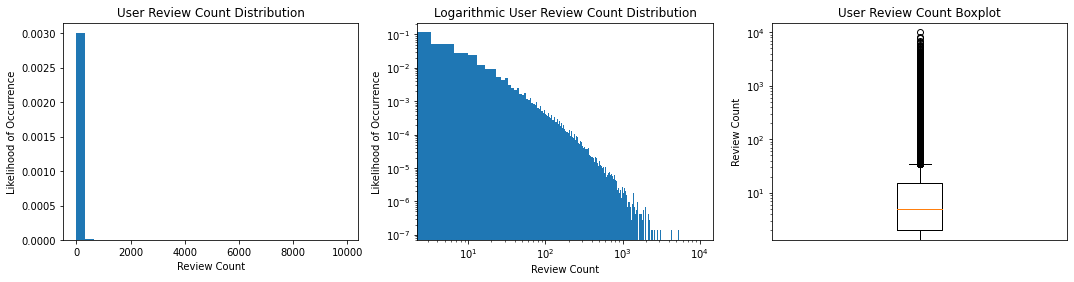

In [44]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].hist(df.review_count, 30, density=True)
ax[0].set_title('User Review Count Distribution')
ax[0].set_ylabel('Likelihood of Occurrence')
ax[0].set_xlabel('Review Count')

ax[1].hist(df.review_count, 3000, density=True)
ax[1].set_title('Logarithmic User Review Count Distribution')
ax[1].set_ylabel('Likelihood of Occurrence')
ax[1].set_yscale('log')
ax[1].set_xlabel('Review Count')
ax[1].set_xscale('log')

ax[2].boxplot(df.review_count)
ax[2].set_title('User Review Count Boxplot')
ax[2].set_ylabel('Review Count')
ax[2].set_yscale('log')
ax[2].set_xticks([])

plt.show()

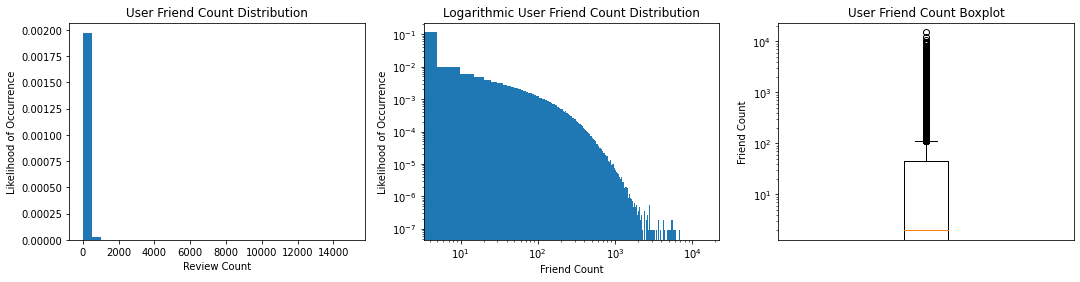

In [58]:
count_friends = lambda x: len(x.split(',')) if x != 'None' else 0
friend_count = df.friends.map(count_friends)

fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].hist(friend_count, 30, density=True)
ax[0].set_title('User Friend Count Distribution')
ax[0].set_ylabel('Likelihood of Occurrence')
ax[0].set_xlabel('Review Count')

ax[1].hist(friend_count, 3000, density=True)
ax[1].set_title('Logarithmic User Friend Count Distribution')
ax[1].set_ylabel('Likelihood of Occurrence')
ax[1].set_yscale('log')
ax[1].set_xlabel('Friend Count')
ax[1].set_xscale('log')

ax[2].boxplot(friend_count)
ax[2].set_title('User Friend Count Boxplot')
ax[2].set_ylabel('Friend Count')
ax[2].set_yscale('log')
ax[2].set_xticks([])

plt.show()

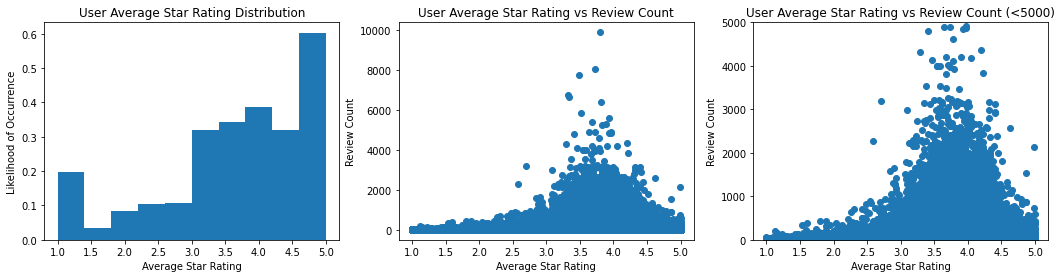

In [54]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].hist(df.average_stars, density=True)
ax[0].set_title('User Average Star Rating Distribution')
ax[0].set_ylabel('Likelihood of Occurrence')
ax[0].set_xlabel('Average Star Rating')

ax[1].scatter(df.average_stars, df.review_count)
ax[1].set_title('User Average Star Rating vs Review Count')
ax[1].set_ylabel('Review Count')
ax[1].set_xlabel('Average Star Rating')

limit = 5000

ax[2].scatter(df.average_stars, df.review_count)
ax[2].set_title('User Average Star Rating vs Review Count (<{0})'.format(limit))
ax[2].set_ylabel('Review Count')
ax[2].set_ylim(0, limit)
ax[2].set_xlabel('Average Star Rating')

plt.show()

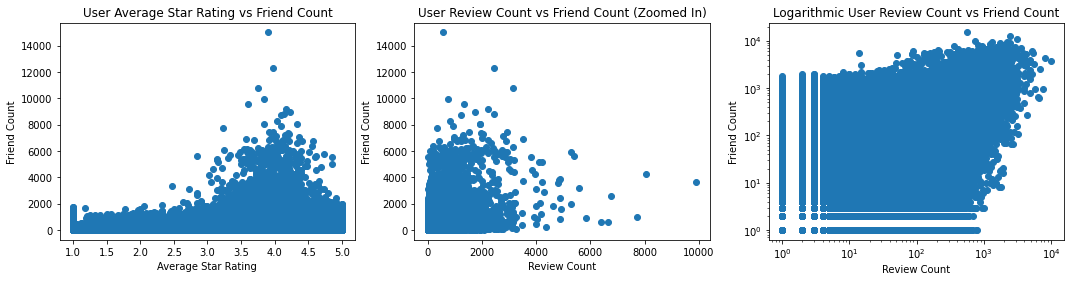

In [115]:
count_friends = lambda x: len(x.split(',')) if x != 'None' else 0
friend_count = df.friends.map(count_friends)

fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].scatter(df.average_stars, friend_count)
ax[0].set_title('User Average Star Rating vs Friend Count')
ax[0].set_ylabel('Friend Count')
ax[0].set_xlabel('Average Star Rating')

ax[1].scatter(df.review_count, friend_count)
ax[1].set_title('User Review Count vs Friend Count')
ax[1].set_xlabel('Review Count')
ax[1].set_ylabel('Friend Count')

ax[2].scatter(df.review_count, friend_count)
ax[2].set_title('Logarithmic User Review Count vs Friend Count')
ax[2].set_xlabel('Review Count')
ax[2].set_xscale('log')
ax[2].set_ylabel('Friend Count')
ax[2].set_yscale('log')


plt.show()

In [104]:
def count_friends_in_data(friends, users):
    """ Returns number of friends 
    
    Arguments
      friends (pd.Series) : friend lists to check if included in users
      users   (pd.Series) : list of all user_id
    
    function(pd.Series, pd.Series) => pd.Series
    """
    def helper(friend_list):
        if friend_list == 'None':
            return 0
        return sum([(users==f).any() for f in friend_list.split(', ')])
    
    return friends.map(helper)

In [103]:
count_friends_in_data(df.friends[10:20], df.user_id)

10     48
11     13
12    158
13     95
14     13
15    145
16    191
17     39
18     84
19     56
Name: friends, dtype: int64

### Review Data

In [108]:
df = clean_review(load_data('yelp_academic_dataset_review.pickle'))

=== Review Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)


In [128]:
print('          Number of Reviews: {0}'.format(len(df)))
print('     Number of Unique Users: {0}'.format(len(df.user_id.unique())))
print('Number of Unique Businesses: {0}'.format(len(df.business_id.unique())))

          Number of Reviews: 8635403
     Number of Unique Users: 2189457
Number of Unique Businesses: 160585


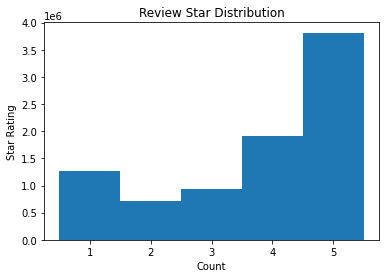

In [129]:
plt.hist(df.stars, bins=[s+0.5 for s in range(0,6)])
plt.title('Review Star Distribution')
plt.ylabel('Star Rating')
plt.xlabel('Count')
plt.show()

=== Reviews by User Summary ===
  Max:    6073
  Mean:   3.944084309488608
  Median: 1.0
  Min:    1


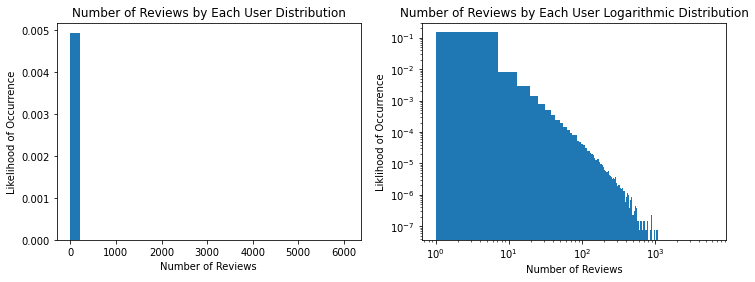

In [69]:
# Count number of reviews by each user in Review set
review_count_user = df.user_id.value_counts()

print('=== Reviews by User Summary ===')
print('  Max:    {0}'.format(max(review_count_user)))
print('  Mean:   {0}'.format(review_count_user.mean()))
print('  Median: {0}'.format(review_count_user.median()))
print('  Min:    {0}'.format(min(review_count_user)))

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(review_count_user, 30, density=True)
ax[0].set_title('Number of Reviews by Each User Distribution')
ax[0].set_xlabel('Number of Reviews')
ax[0].set_ylabel('Likelihood of Occurrence')

ax[1].hist(review_count_user, 1000, density=True)
ax[1].set_title('Number of Reviews by Each User Logarithmic Distribution')
ax[1].set_xlabel('Number of Reviews')
ax[1].set_xscale('log')
ax[1].set_ylabel('Liklihood of Occurrence')
ax[1].set_yscale('log')

=== Reviews of Business Summary ===
  Max:    6073
  Mean:   3.944084309488608
  Median: 1.0
  Min:    1


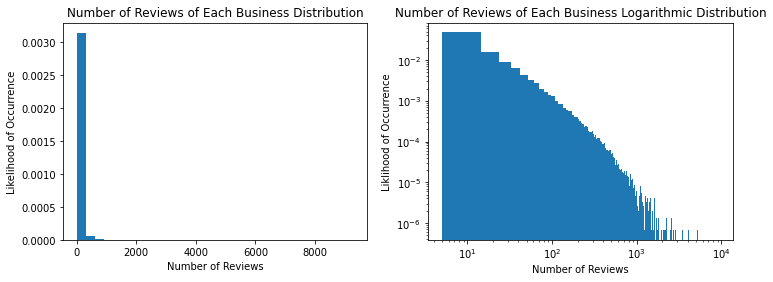

In [70]:
# Count number of reviews for each business in Review set
review_count_business = df.business_id.value_counts()

print('=== Reviews of Business Summary ===')
print('  Max:    {0}'.format(max(review_count_user)))
print('  Mean:   {0}'.format(review_count_user.mean()))
print('  Median: {0}'.format(review_count_user.median()))
print('  Min:    {0}'.format(min(review_count_user)))


fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(review_count_business, 30, density=True)
ax[0].set_title('Number of Reviews of Each Business Distribution')
ax[0].set_xlabel('Number of Reviews')
ax[0].set_ylabel('Likelihood of Occurrence')

ax[1].hist(review_count_business, 1000, density=True)
ax[1].set_title('Number of Reviews of Each Business Logarithmic Distribution')
ax[1].set_xlabel('Number of Reviews')
ax[1].set_xscale('log')
ax[1].set_ylabel('Liklihood of Occurrence')
ax[1].set_yscale('log')

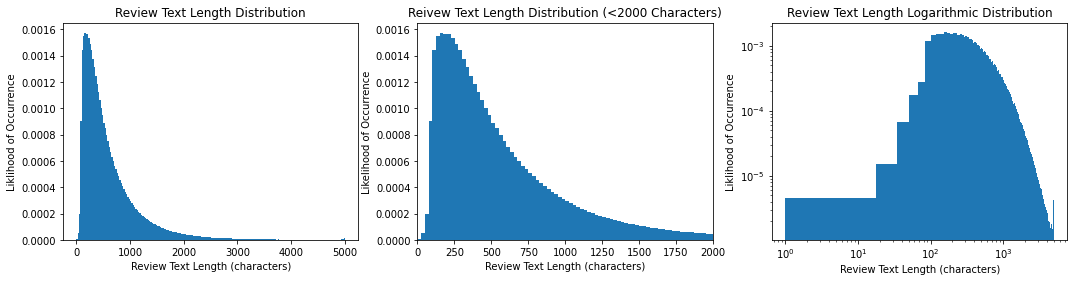

In [63]:
text_len = df.text.map(len)

fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].hist(text_len, 200, density=True)
ax[0].set_title('Review Text Length Distribution')
ax[0].set_xlabel('Review Text Length (characters)')
ax[0].set_ylabel('Liklihood of Occurrence')

ax[1].hist(text_len, 200, density=True)
ax[1].set_title('Reivew Text Length Distribution (<2000 Characters)')
ax[1].set_xlabel('Review Text Length (characters)')
ax[1].set_xlim(0, 2000)
ax[1].set_ylabel('Likelihood of Occurrence')

ax[2].hist(text_len, 300, density=True)
ax[2].set_title('Review Text Length Logarithmic Distribution')
ax[2].set_xlabel('Review Text Length (characters)')
ax[2].set_xscale('log')
ax[2].set_ylabel('Liklihood of Occurrence')
ax[2].set_yscale('log')

plt.show()

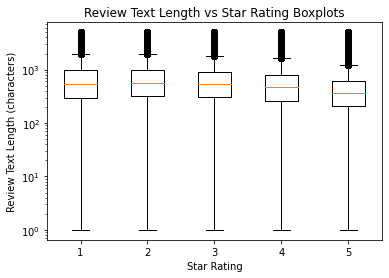

In [87]:
star_values = [i for i in range(1,6)]
star_bins = [df[df.stars==s].text.map(len) for s in star_values]

plt.boxplot(star_bins)
plt.title('Review Text Length vs Star Rating Boxplots')
plt.xlabel('Star Rating')
plt.ylabel('Review Text Length (characters)')
plt.yscale('log')

plt.show()

### Combinations of Data

In [107]:
df_bus = clean_business(load_data('yelp_academic_dataset_business.pickle'))
df_rev = clean_review(load_data('yelp_academic_dataset_review.pickle'))

=== Business Data Cleaning Results ===
  Null entries dropped:   27341 (17.03%)
  Duplicate business_id:  0
=== Review Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)


In [158]:
def build_q3_df(review_data, business_data):
    """Build pd.DataFrame with information to analyze Q3 of the project

    Resulting DataFrame has the following columns:
      [0] review_id (String)
      [1] in_hours  (Boolean)
      [2] stars     (Number)
    
    function(pd.DataFrame, pd.Dataframe) => pd.DataFrame
    """
    def helper(rev):
        
        bus = business_data[business_data.business_id == rev.business_id]
        
        if len(bus) == 0:
            # Business data for review not in dataset
            return None        
        bus = bus.iloc[0]

        in_hours = in_business_hours(rev.date, bus.hours)

        return [rev.review_id, in_hours, rev.stars]
    
    
    q3 = review_data.apply(helper, axis=1, result_type='expand').dropna()
    q3.columns = ['review_id', 'in_hours', 'stars']
    q3 = q3.astype({'review_id': 'object', 'in_hours': 'bool', 'stars': 'float64'})
    
    return q3


In [159]:
# q3 = build_q3_df(df_rev, df_bus)
q3 = build_q3_df(df_rev.sample(n=10000), df_bus)

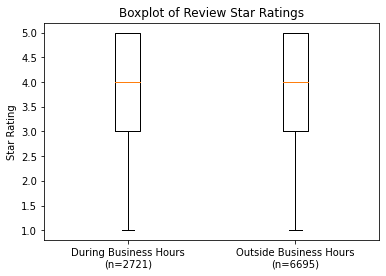

In [166]:
stars_in_hours = q3[q3.in_hours].stars
stars_out_hours = q3[~q3.in_hours].stars

plt.boxplot([stars_in_hours, stars_out_hours])
plt.title('Boxplot of Review Star Ratings')
plt.ylabel('Star Rating')
plt.xticks([1,2], ['During Business Hours\n(n={0})'.format(len(stars_in_hours)), 'Outside Business Hours\n(n={0})'.format(len(stars_out_hours))])

plt.show()

## Statistics and Modeling

### Problem 1: User Activity and Average Rating

In [167]:
df = clean_user(load_data('yelp_academic_dataset_user.pickle'))

=== User Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)
  Duplicate user_id:     0
  Outliers removed:      4
